In [1]:
%load_ext autoreload
%autoreload 2

# Inference on on-purpose mirrored Images

## 1. Loading mirrored images

We perform inference over the Test Set, so we load images indexes.

In [2]:
from matplotlib import pyplot as plt
from model.left_hand import ExternalHand, ExternalLeftHand
from settings import LEFT_RIGHT_MODEL_CONFIG, HANDPOSE_MODEL_CONFIG

In [6]:
def model_comparison(file_name: str):
    
    hand1 = ExternalHand(file_name=file_name, config=HANDPOSE_MODEL_CONFIG)
    hand2 = ExternalLeftHand(file_name=file_name, classifier_config=LEFT_RIGHT_MODEL_CONFIG, estimator_config=HANDPOSE_MODEL_CONFIG)

    # Subplots
    fig, axes = plt.subplots(1, 2, figsize=(7, 4))

    for ax, hand, title in zip([0, 1], [hand1, hand2], ["No classification", "With classification"]):

        axes[ax].imshow(hand.pred_skeleton)
        axes[ax].axis('off')
        axes[ax].set_title(title)

    # Add a title for both images
    plt.suptitle(f"{file_name} - Comparison")
    plt.show()

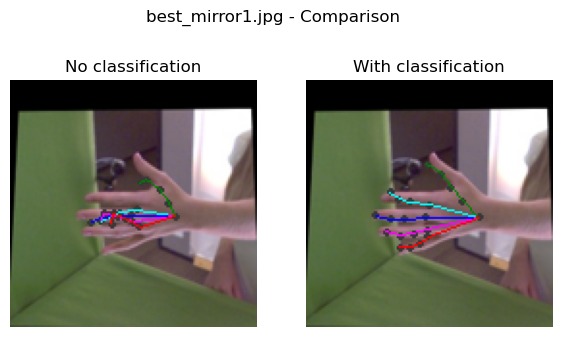

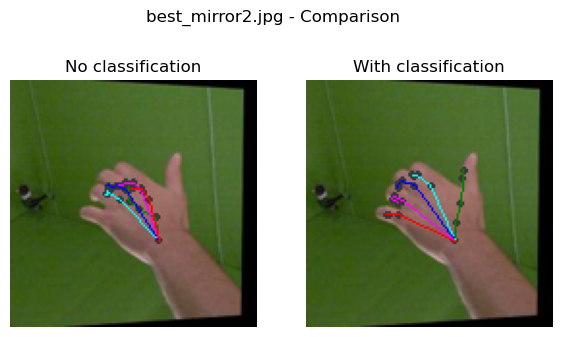

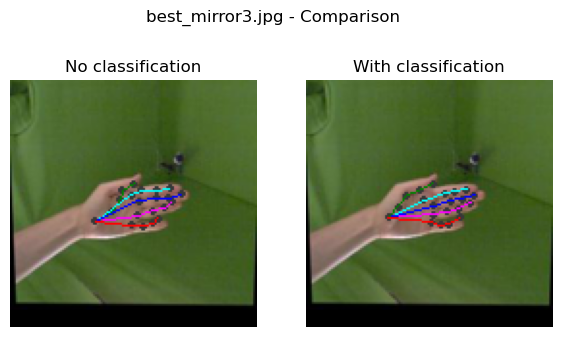

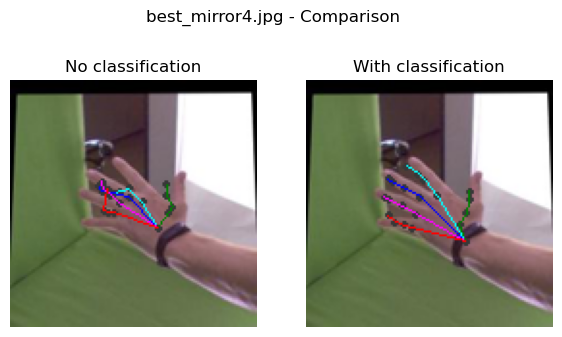

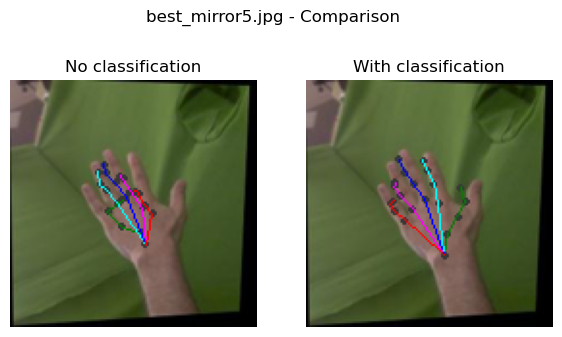

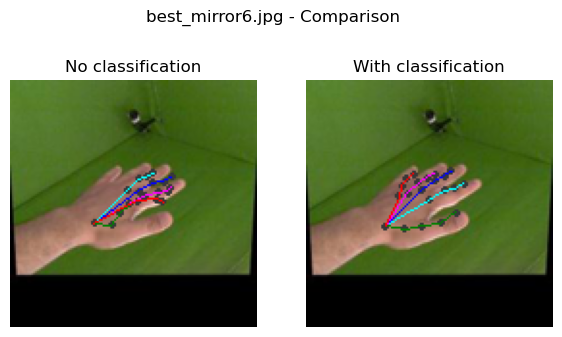

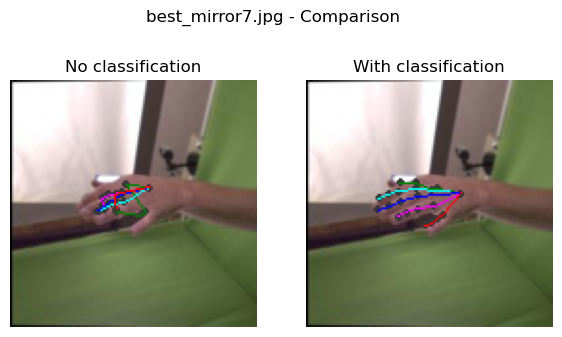

In [9]:
for i in range(1, 8):
    model_comparison(file_name=f"best_mirror{i}.jpg")

## 2. Random select mirrored images

In [17]:
from PIL import Image
import os
import random

from io_ import get_external_images, get_images_dir
from settings import DATA, PRC
from model.dataset import FreiHANDSplitter

def mirror_random_images(n: int = 10):

    # Directories
    in_dir = get_images_dir()
    out_dir = get_external_images()

    # Generate random unique indices
    a, b = FreiHANDSplitter(n=DATA["n_data"], percentages=list(PRC.values())).test_bounds
    random_indices = random.sample(range(b - a), n)
    random_indices = [i + a for i in random_indices]

    # Iterate through the selected indices
    for i, idx in enumerate(random_indices):
        
        # Generate original image filename
        original_filename = f"{idx:08d}.jpg"
        original_path = os.path.join(in_dir, original_filename)
    
        # Load the original image
        original_image = Image.open(original_path)
    
        # Mirror the image horizontally
        mirrored_image = original_image.transpose(Image.FLIP_LEFT_RIGHT)
    
        # Generate mirrored image filename
        mirrored_filename = f"rand_mirror{i+1}.jpg"
        mirrored_path = os.path.join(out_dir, mirrored_filename)
    
        # Save the mirrored image to the output directory
        mirrored_image.save(mirrored_path)

In [20]:
n = 10
mirror_random_images(n=n)

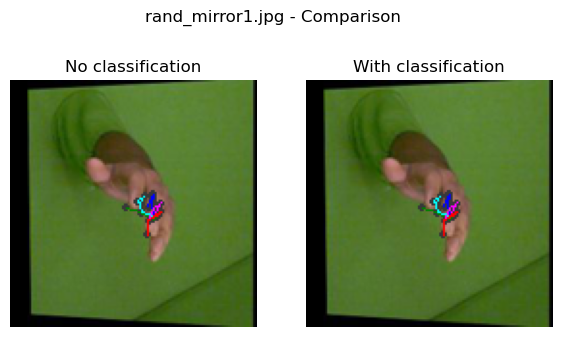

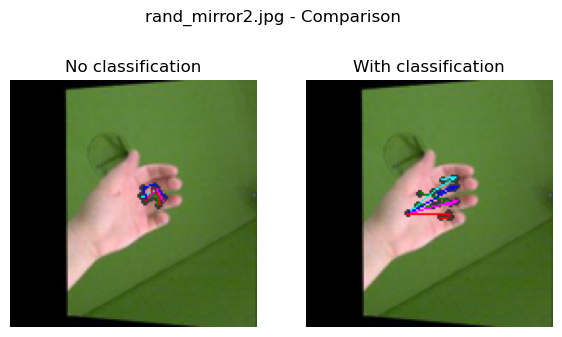

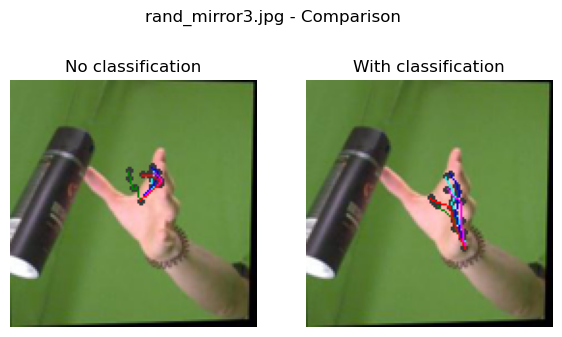

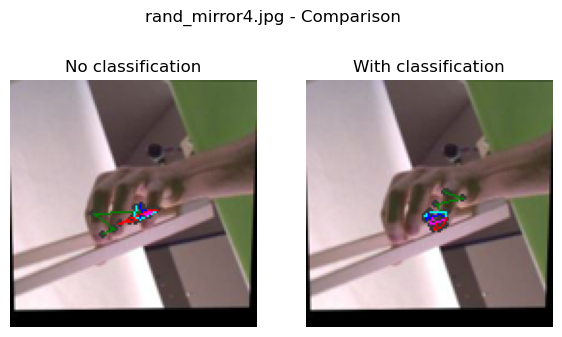

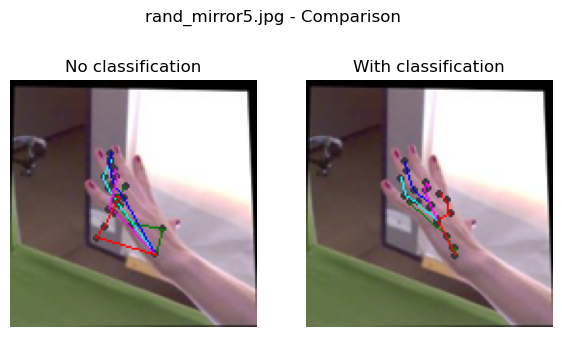

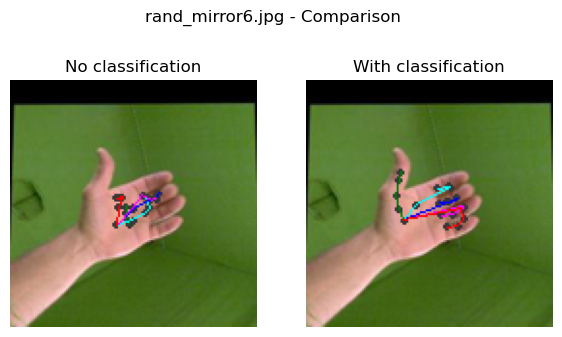

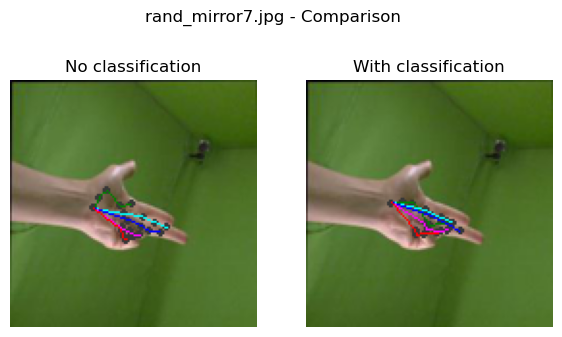

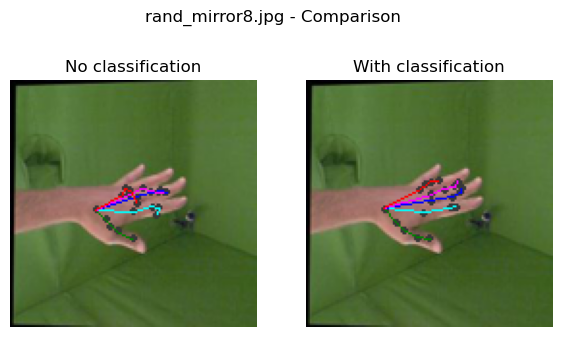

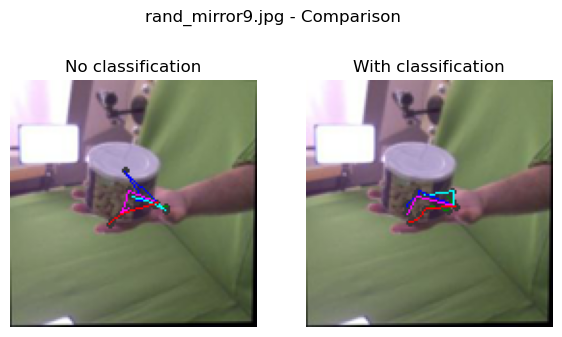

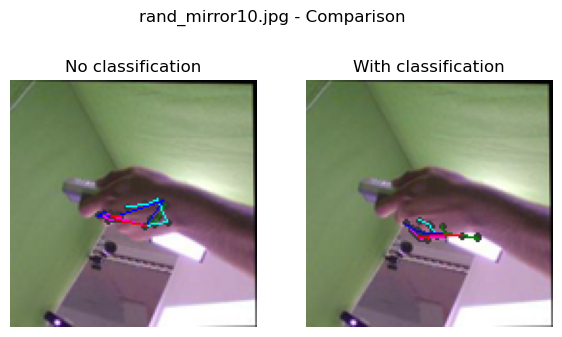

In [21]:
for i in range(1, n+1):
    model_comparison(file_name=f"rand_mirror{i}.jpg")